In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.asyncd import utils
from otf.system import System_ModelKnown

from plot import plot

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, 1, -1], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0

In [ ]:
def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    sigma, rho, beta = gs

    x, y, z = true

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    sigma, rho, beta = cs

    x, y, z = nudged

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


# System evolution parameters
sigma, rho, beta = g1, g2, g3 = 10, 28, 8 / 3
c1, c2, c3 = g1, g2, g3
c1 *= 1.1
c2 *= 0.9
c3 *= 1.1
mu = 10

gs = jnp.array([g1, g2, g3])
cs = jnp.array([c1, c2, c3])

true0, assimilated0 = get_initial_values()

observed_mask = jnp.array([0, 1, 1], dtype=bool)
system = System_ModelKnown(mu, gs, cs, observed_mask, assimilated_ode, true_ode)

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 1600
t_relax = 0.5

gradient_computer = optim.gradient.AdjointGradient(
    system,
    dt,
    optim.gradient.adjoint.UpdateOption.unobserved,
    (ti.ForwardEuler,),
)
optimizer = optax.adam(1e-2)
optimizer = optim.OptaxWrapper(system, optimizer, gradient_computer)

true_solver = solver
trues, tls_ = true_solver.solve_true(true0, T0, Tf, dt)

true_observed = trues[:, system.observed_mask]

cs, u_errors, tls, assimilateds = utils.run_update(
    system,
    true_observed,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    assimilated0,
    optimizer=optimizer,
    return_all=True,
    t_begin_updates=50,
)

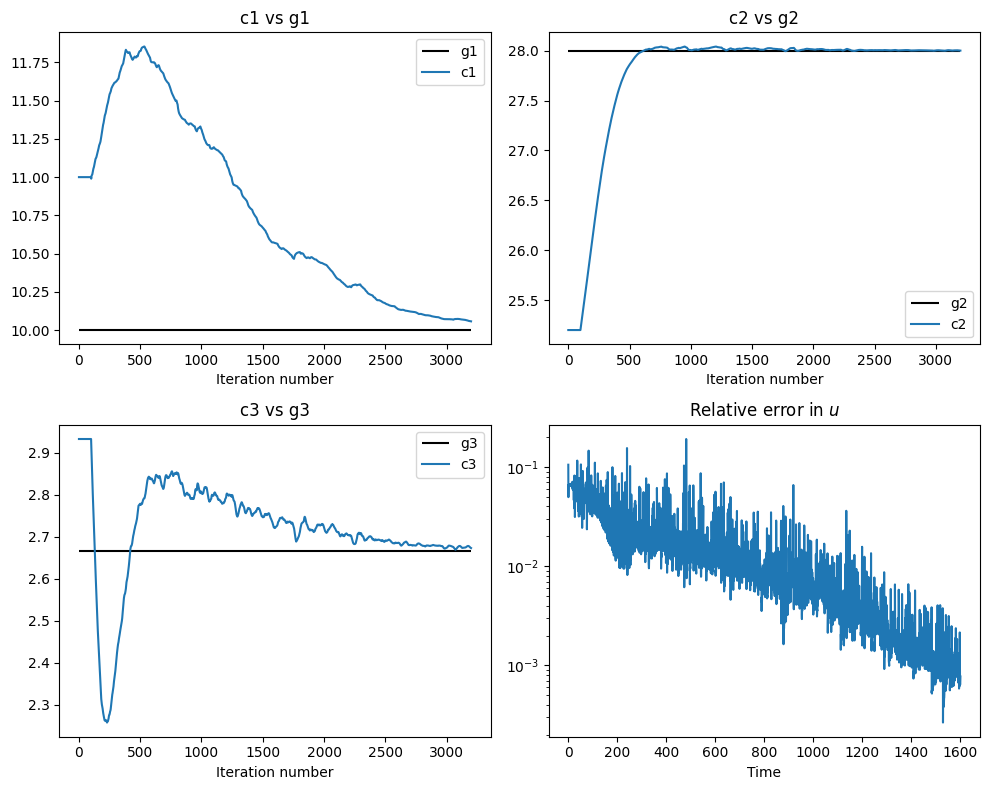

In [ ]:
fig, axs = plot(cs.T[0], cs.T[1], cs.T[2], u_errors, g1, g2, g3, tls)
plt.show()

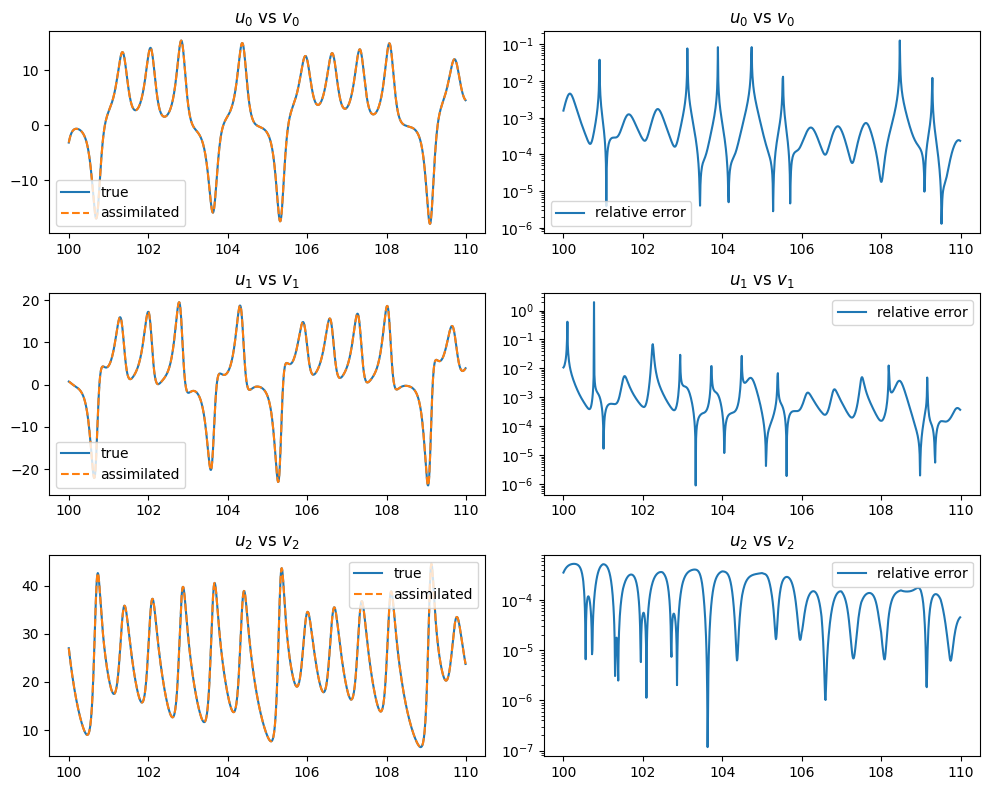

In [ ]:
tn, n = trues.shape
tls = jnp.arange(tn) * dt

start, end = 100, 110
start_idx, end_idx = int(start / dt), int(end / dt)
s_ = jnp.s_[start_idx:end_idx]

fig, axs = plt.subplots(3, 2, figsize=(10, 8))

for i, (true, assimilated, ax) in enumerate(
    zip(trues.T, assimilateds.T, axs[:, 0])
):
    ax.plot(tls[s_], true[s_], label="true")
    ax.plot(tls[s_], assimilated[s_], label="assimilated", ls="--")
    ax.legend()
    ax.set_title(f"$u_{{{i}}}$ vs $v_{{{i}}}$")

for i, (true, assimilated, ax) in enumerate(
    zip(trues.T, assimilateds.T, axs[:, 1])
):
    ax.plot(
        tls[s_],
        abs(true[s_] - assimilated[s_]) / abs(true[s_]),
        label="relative error",
    )
    ax.set_yscale("log")
    ax.legend()
    ax.set_title(f"$u_{{{i}}}$ vs $v_{{{i}}}$")

fig.tight_layout()
plt.show()